In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,ShuffleSplit,learning_curve,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.metrics import confusion_matrix
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA,TruncatedSVD
import matplotlib.patches as mpatches
import time

#Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

#Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import KFold,StratifiedKFold
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('creditcard.csv',sep=',')
print('No Frauds {0} of the dataset'.format(df[df['Class']==0].shape[0]/df.shape[0]))
print('Frauds {0} of dataset'.format(df[df['Class']==1].shape[0]/df.shape[0]))

No Frauds 0.9982725143693799 of the dataset
Frauds 0.001727485630620034 of dataset


In [4]:
# Since most of our data has already bean scaled 
# We should scale the columns that are left to scale (Amount and Time)
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'],axis=1,inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount','scaled_time'],axis=1,inplace=True)
df.insert(0,'scaled_amount',scaled_amount)
df.insert(1,'scaled_time',scaled_time)

In [5]:
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting the Data (Original DataFrame)

In [6]:
X = df.drop('Class',axis=1)
y = df['Class']
sss = StratifiedShuffleSplit(n_splits=5,random_state=42)
for train_index,test_index in sss.split(X,y):
    print('Train:',train_index.shape,"Test:",test_index.shape)
    original_Xtrain,original_Xtest = X.iloc[train_index],X.iloc[test_index]
    original_ytrain,original_ytest = y.iloc[train_index],y.iloc[test_index]
    
original_Xtrain = original_Xtrain.values
original_ytrain = original_ytrain.values
original_Xtest = original_Xtest.values
original_ytest = original_ytest.values

Train: (256326,) Test: (28481,)
Train: (256326,) Test: (28481,)
Train: (256326,) Test: (28481,)
Train: (256326,) Test: (28481,)
Train: (256326,) Test: (28481,)


# Random UnderSample

(284807, 31)
fraud shape: (492, 31)
non fraud shape: (492, 31)
Distribution of the Classes in the subsample dataset
1    0.001727
0    0.001727
Name: Class, dtype: float64


Text(0.5, 1.0, 'Equally Distributed Classes')

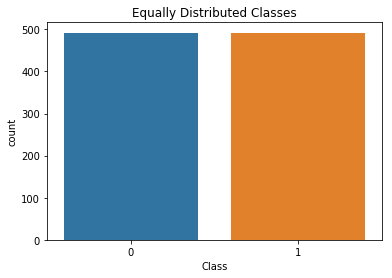

In [7]:
print(df.shape)
df = df.sample(frac=1)
fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:492]
print('fraud shape:',fraud_df.shape)
print('non fraud shape:',non_fraud_df.shape)
normal_distributed_df = pd.concat([fraud_df,non_fraud_df])
#shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1,random_state=42)
new_df.head()
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(df))
sns.countplot('Class',data = new_df)
plt.title('Equally Distributed Classes')

# Anormaly Detection
### Our main aim in this section is to remove "extreme outlier" from features that have a high correlation with our classes.This will have a positive impact on the accuracy of our models


In [8]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)


# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.049997689859396, -18.4937733551053, -18.8220867423816, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.683714633344298, -18.553697009645802, -18.4311310279993, -18.047596570821604]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-22.1870885620007, -

In [9]:
# Undersampling before cross validating 
X = new_df.drop('Class',axis=1)
y = new_df['Class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [32]:
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.utils.np_utils import to_categorical

In [33]:
y_train = to_categorical(y_train)
print(X_train.shape,y_train.shape)

n_inputs = X_train.shape[1]
undersample_model = Sequential([
    Dense(n_inputs,input_shape=(n_inputs,),activation='relu'),
    Dense(32,activation='relu'),
    Dense(2,activation='softmax')]
)


(757, 30) (757, 2)


In [34]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_17 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [46]:
undersample_model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
undersample_model.fit(X_train,y_train,validation_split=0.2,batch_size=25,epochs=20,shuffle=True,verbose=2)

Train on 605 samples, validate on 152 samples
Epoch 1/20
 - 0s - loss: 0.0637 - acc: 0.9785 - val_loss: 0.2127 - val_acc: 0.9408
Epoch 2/20
 - 0s - loss: 0.0571 - acc: 0.9818 - val_loss: 0.2169 - val_acc: 0.9408
Epoch 3/20
 - 0s - loss: 0.0537 - acc: 0.9818 - val_loss: 0.2220 - val_acc: 0.9408
Epoch 4/20
 - 0s - loss: 0.0507 - acc: 0.9835 - val_loss: 0.2248 - val_acc: 0.9408
Epoch 5/20
 - 0s - loss: 0.0477 - acc: 0.9835 - val_loss: 0.2281 - val_acc: 0.9408
Epoch 6/20
 - 0s - loss: 0.0435 - acc: 0.9851 - val_loss: 0.2364 - val_acc: 0.9408
Epoch 7/20
 - 0s - loss: 0.0412 - acc: 0.9901 - val_loss: 0.2461 - val_acc: 0.9342
Epoch 8/20
 - 0s - loss: 0.0395 - acc: 0.9868 - val_loss: 0.2483 - val_acc: 0.9408
Epoch 9/20
 - 0s - loss: 0.0369 - acc: 0.9901 - val_loss: 0.2535 - val_acc: 0.9474
Epoch 10/20
 - 0s - loss: 0.0368 - acc: 0.9868 - val_loss: 0.2573 - val_acc: 0.9408
Epoch 11/20
 - 0s - loss: 0.0326 - acc: 0.9917 - val_loss: 0.2598 - val_acc: 0.9408
Epoch 12/20
 - 0s - loss: 0.0317 - acc:

In [48]:
undersample_predictions = undersample_model.predict(original_Xtest,batch_size=200,verbose=0)

In [49]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest,batch_size=200,verbose=0)

In [50]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[26858  1574]
 [    2    47]]
Confusion matrix, without normalization
[[28432     0]
 [    0    49]]


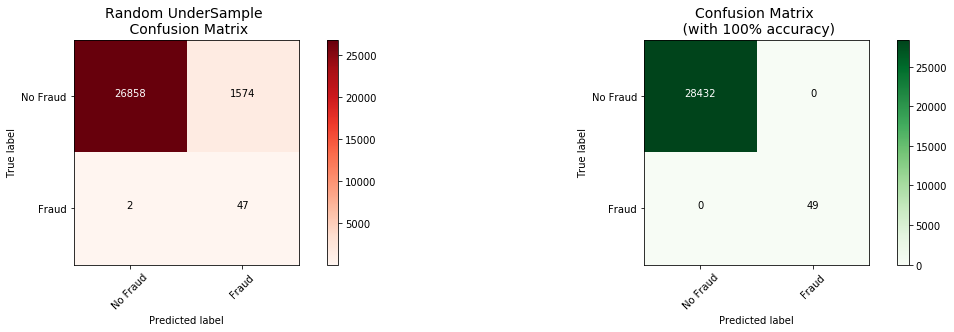

In [42]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# Keras || OverSampling(SMOTE)

In [64]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)
# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
print(Counter(ysm_train))

n_inputs = Xsm_train.shape[1]
oversample_model = Sequential([
    Dense(n_inputs,input_shape=(n_inputs,),activation='relu'),
    Dense(32,activation='relu'),
    Dense(2,activation='softmax')
])

Counter({0: 255883, 1: 255883})


In [65]:
oversample_model.compile(Adam(lr=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
oversample_model.fit(Xsm_train,ysm_train,validation_split=0.2,batch_size=300,shuffle=True,verbose=2)

Train on 409412 samples, validate on 102354 samples
Epoch 1/10
 - 3s - loss: 0.0237 - acc: 0.9924 - val_loss: 0.0082 - val_acc: 0.9982
Epoch 2/10
 - 3s - loss: 0.0075 - acc: 0.9982 - val_loss: 7.6338e-04 - val_acc: 1.0000
Epoch 3/10
 - 3s - loss: 0.0063 - acc: 0.9986 - val_loss: 0.0164 - val_acc: 0.9943
Epoch 4/10
 - 3s - loss: 0.0053 - acc: 0.9987 - val_loss: 0.0017 - val_acc: 0.9996
Epoch 5/10
 - 3s - loss: 0.0055 - acc: 0.9987 - val_loss: 0.0022 - val_acc: 0.9999
Epoch 6/10
 - 3s - loss: 0.0043 - acc: 0.9990 - val_loss: 0.0012 - val_acc: 0.9996
Epoch 7/10
 - 3s - loss: 0.0040 - acc: 0.9991 - val_loss: 0.0020 - val_acc: 0.9998
Epoch 8/10
 - 3s - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0317 - val_acc: 0.9973
Epoch 9/10
 - 3s - loss: 0.0038 - acc: 0.9991 - val_loss: 6.8282e-04 - val_acc: 1.0000
Epoch 10/10
 - 3s - loss: 0.0040 - acc: 0.9992 - val_loss: 0.0041 - val_acc: 0.9987


In [66]:
oversample_predictions = oversample_model.predict(original_Xtest,batch_size=200,verbose=0)
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest,batch_size=200,verbose=0)

Confusion matrix, without normalization
[[28398    34]
 [   10    39]]
Confusion matrix, without normalization
[[28432     0]
 [    0    49]]


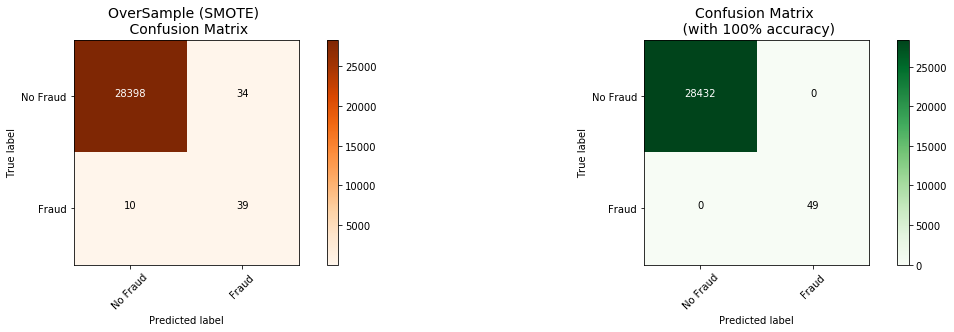

In [67]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)